# Hourly clustering over whole year 2024

In [1]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
#from validation import validation_KMeans
from cluster_statistics_kMeans import plot_cluster_percentiles
from Hyperparameters_KMeans import optimize_kmeans

dataset = "SWW" 

## Data Clustering

In [2]:

input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized")
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data_{dataset}.xlsx")

if dataset == "SWW":
    df = pd.read_excel(file_path,skiprows=4,nrows=1500,header=None,dtype={10: str, 142: str})
    cols_to_extract = [10, 142]
elif dataset == "GroupE":
    df = pd.read_excel(file_path,skiprows=3,nrows=1500,header=None,dtype={0: str, 148: str})
    cols_to_extract = [0, 148]


extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['resident_id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_resident_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_resident_ids}")

if total_rows > unique_resident_ids:
    print(f"There are {total_rows - unique_resident_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

Total rows: 1500
Unique resident_id count: 1500
No duplicates found in house_id column.


In [3]:
category_df = extracted_df.copy()
category_df = category_df[category_df['Building Type'] != 'No Information']

category_df_tot = category_df.copy()

category_df_flat = category_df[category_df['Building Type'] != 'House']

category_df_house = category_df[category_df['Building Type'] != 'Flat']


category_df_tot = category_df_tot.drop(columns=['Building Type'])
#category_df_tot = category_df_tot.drop(columns=['resident_id'])

category_df_flat = category_df_flat.drop(columns=['Building Type'])
#category_df_flat = category_df_flat.drop(columns=['resident_id'])

category_df_house = category_df_house.drop(columns=['Building Type'])
#category_df_house = category_df_house.drop(columns=['resident_id'])


In [4]:
input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized")

n_timestamps = 96

# Alle CSV-Dateien
pattern = str(input_folder / "*.csv")
file_paths = glob.glob(pattern)


clusters_train = {}
train_data = {}

for cat, categories in enumerate([category_df_tot, category_df_flat, category_df_house]):

    valid_ids = set(categories["resident_id"].astype(str))

    data_list = []

    for file_path in file_paths:
        df = pl.read_csv(file_path)

        base = os.path.basename(file_path)
        resid, _ = os.path.splitext(base)

        if resid not in valid_ids:
            continue

        if len(df) != n_timestamps:
            continue

        values_array = (
            df["day_avg_bruttolastgang_kwh"]
            .to_numpy()
            .reshape((1, n_timestamps, 1))
        )
        data_list.append(values_array)

    if data_list:
        data_3d = np.concatenate(data_list, axis=0)
        print(f"Shape of the 3D array: {data_3d.shape}")

    train_data[cat] = data_3d

    clusters_train[cat] = cat*np.ones(len(data_3d))

Shape of the 3D array: (1277, 96, 1)
Shape of the 3D array: (801, 96, 1)
Shape of the 3D array: (476, 96, 1)


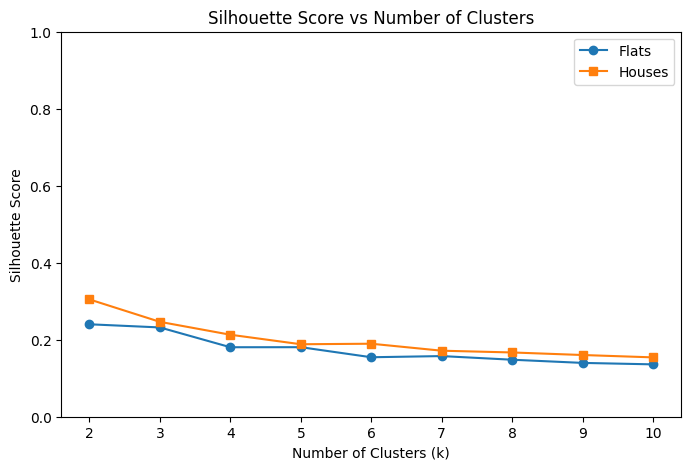

Minimum Silhouette Score Dataset 1: 0.2400957408537981
Minimum Silhouette Score Dataset 2: 0.3046812502556417


(shape: (9, 2)
 ┌────────────────┬──────────────────┐
 │ no_of_clusters ┆ silhouette_score │
 │ ---            ┆ ---              │
 │ i64            ┆ f64              │
 ╞════════════════╪══════════════════╡
 │ 2              ┆ 0.240096         │
 │ 3              ┆ 0.231897         │
 │ 4              ┆ 0.180476         │
 │ 5              ┆ 0.180602         │
 │ 6              ┆ 0.15448          │
 │ 7              ┆ 0.157512         │
 │ 8              ┆ 0.148045         │
 │ 9              ┆ 0.139791         │
 │ 10             ┆ 0.136            │
 └────────────────┴──────────────────┘,
 shape: (9, 2)
 ┌────────────────┬──────────────────┐
 │ no_of_clusters ┆ silhouette_score │
 │ ---            ┆ ---              │
 │ i64            ┆ f64              │
 ╞════════════════╪══════════════════╡
 │ 2              ┆ 0.304681         │
 │ 3              ┆ 0.246421         │
 │ 4              ┆ 0.212963         │
 │ 5              ┆ 0.188251         │
 │ 6              ┆ 0.189606     

In [5]:
train_data1 = train_data[1]
train_data2 = train_data[2]

from importlib import reload
import validation
from validation import validation_kMeans
reload(validation)


validation_kMeans(train_data1, train_data2, dataset)

# Plotting the cluster average patterns

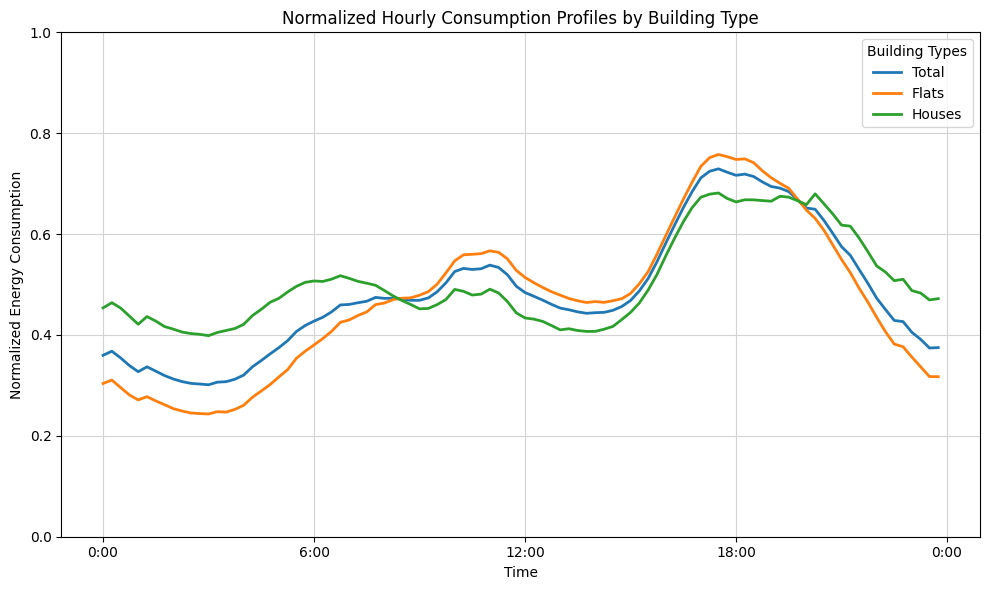

In [6]:
# Plot-Funktion, um alle Kategorien zusammen darzustellen
def plot_all_categories_together(train_data, clusters_train):
    labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
    legend_titles = ['Total', 'Flats', 'Houses']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    plt.figure(figsize=(10,6))
    
    for cat in range(len(train_data)):
        data = train_data[cat]
        if data.shape[0] == 0:
            continue
        
        # Mittlere Zeitreihe über alle Samples
        mean_time_series = np.mean(data, axis=0)
        plt.plot(range(1, 97), mean_time_series.ravel(),
                 label=legend_titles[cat],
                 linewidth=2,
                 color=colors[cat])
        
    plt.title('Normalized Hourly Consumption Profiles by Building Type')
    plt.xlabel('Time')
    plt.ylabel('Normalized Energy Consumption')
    plt.ylim(0, 1)
    plt.xticks(ticks=[1, 25, 49, 73, 97], labels=labels)
    plt.grid(True, color='lightgray')
    plt.legend(title = 'Building Types',loc='upper right', fontsize='medium')
    plt.tight_layout()
    
    plt.savefig(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/HourlyAveraged_AllCategories_{dataset}.png", bbox_inches='tight')
    plt.show()

# Aufruf des Plots
plot_all_categories_together(train_data, clusters_train)